In [ ]:
!pip install kagglehub --quiet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from PIL import Image
import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array, array_to_img, to_categorical
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split

In [ ]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


In [ ]:
dataset_path = '/kaggle/input/plantdisease'
if not os.path.exists(dataset_path):
    import kagglehub
    kagglehub.dataset_download("emmarex/plantdisease", path=dataset_path)
    print("Dataset downloaded.")
else:
    print("Dataset already exists. Skipping download.")

Dataset already exists. Skipping download.


In [ ]:
import os

for root, dirs, files in os.walk('/kaggle/input/plantdisease'):
    print(f"Root: {root}")
    print("Dirs:", dirs)
    print("Files:", files[:5])  # Show a few file names for each directory
    print("-----")


Root: /kaggle/input/plantdisease
Dirs: ['PlantVillage', 'plantvillage']
Files: []
-----
Root: /kaggle/input/plantdisease/PlantVillage
Dirs: ['Pepper__bell___Bacterial_spot', 'Potato___healthy', 'Tomato_Leaf_Mold', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Early_blight', 'Tomato__Target_Spot', 'Pepper__bell___healthy', 'Potato___Late_blight', 'Tomato_Late_blight', 'Potato___Early_blight', 'Tomato__Tomato_mosaic_virus']
Files: []
-----
Root: /kaggle/input/plantdisease/PlantVillage/Pepper__bell___Bacterial_spot
Dirs: []
Files: ['0f72db9c-d635-4415-9781-68937328aed2___NREC_B.Spot 9188.JPG', '1b8d3e98-43d9-441d-93ef-a359e6e9ddc2___NREC_B.Spot 9052.JPG', 'b6d35d21-4812-4e32-ab9a-b6ddda8cbb79___JR_B.Spot 8972.JPG', 'e4e7e5a2-5aa1-4378-833d-9142358c7c9b___JR_B.Spot 9092.JPG', '8b50f2db-cbf2-4758-bea6-a011f0cc1497___JR_B.Spot 3235.JPG']
-----
Root: /kaggle/input/plantdis

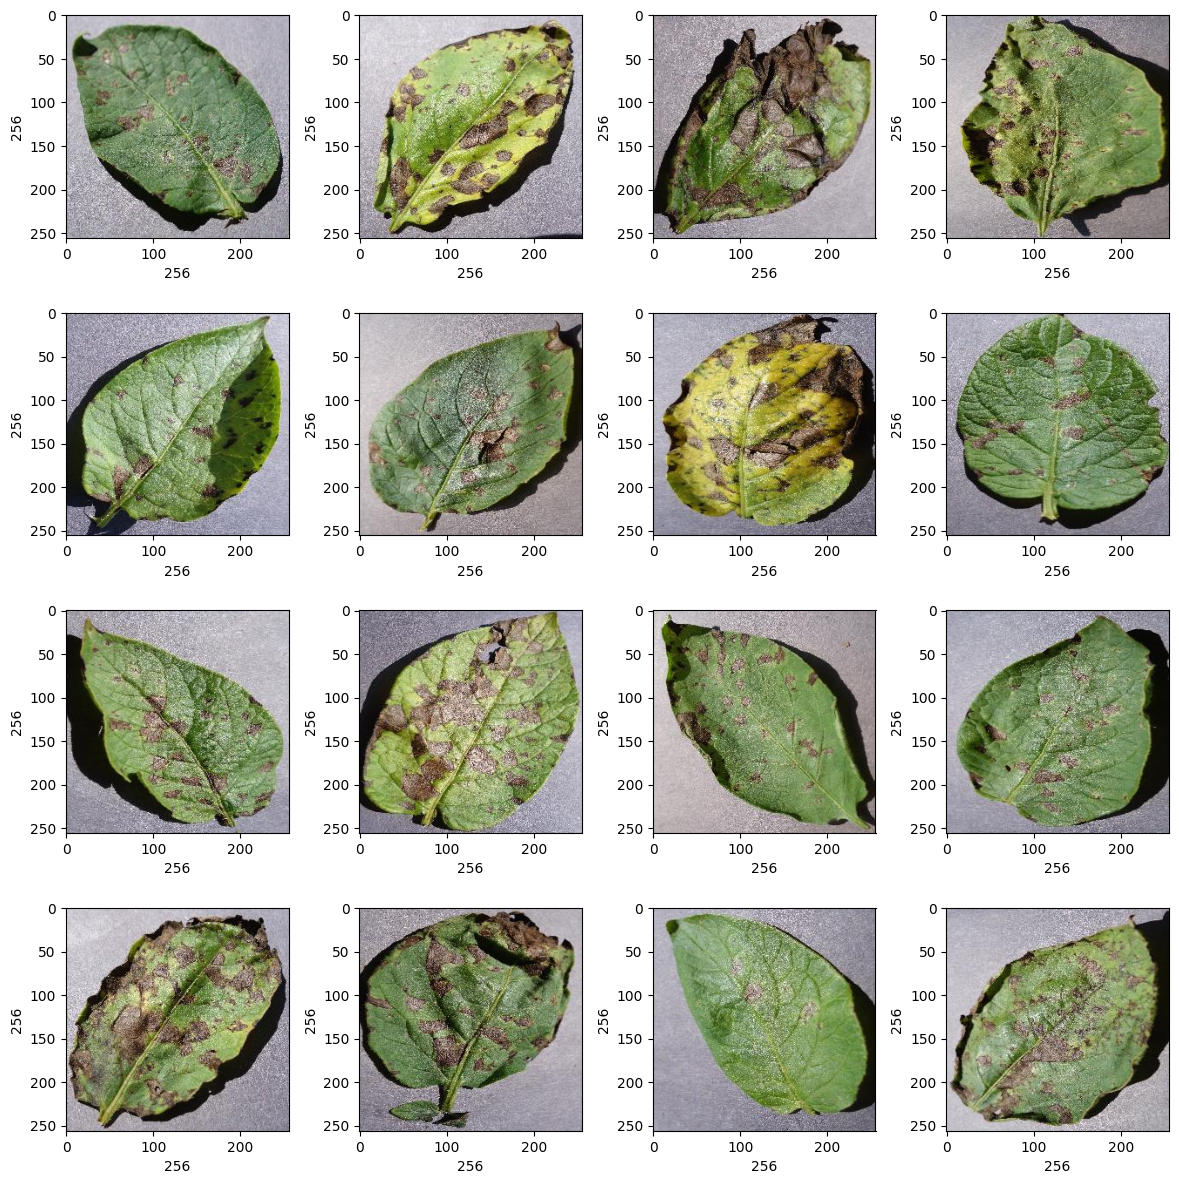

In [ ]:
subfolder_path = '/kaggle/input/plantdisease/PlantVillage/Potato___Early_blight'
plt.figure(figsize=(12, 12))
for i in range(1, 17):
    plt.subplot(4, 4, i)
    plt.tight_layout()
    rand_img = imread(os.path.join(subfolder_path, random.choice(sorted(os.listdir(subfolder_path)))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize=10)  # width of image
    plt.ylabel(rand_img.shape[0], fontsize=10)  # height of image
plt.show()


In [ ]:
# 5. Convert Images to Numpy Arrays & Prepare Labels
def convert_image_to_array(image_dir):
    try:
        img = cv2.imread(image_dir)
        if img is not None:
            img = cv2.resize(img, (256, 256))
            return img_to_array(img)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

labels = os.listdir(dataset_path)
# Use only three classes for this notebook (for full dataset, expand these lists)
all_labels = ['Corn_(maize)___Common_rust_', 'Potato___Early_blight', 'Tomato___Bacterial_spot']
binary_labels = [0, 1, 2]

image_list, label_list = [], []
for idx, directory in enumerate(all_labels):
    curr_dir = os.path.join(dataset_path, directory)
    if not os.path.isdir(curr_dir):
        continue
    files = os.listdir(curr_dir)
    for file in files:
        image_path = os.path.join(curr_dir, file)
        img_arr = convert_image_to_array(image_path)
        if img_arr.shape == (256, 256, 3):  # Sanity check
            image_list.append(img_arr)
            label_list.append(binary_labels[idx])

image_list = np.array(image_list, dtype=np.float16)
label_list = np.array(label_list)
print("Classes found:", all_labels)
print("Image samples:", len(image_list))

Classes found: ['Corn_(maize)___Common_rust_', 'Potato___Early_blight', 'Tomato___Bacterial_spot']
Image samples: 0


In [ ]:
# 6. Check for Class Imbalance
label_counts = pd.Series(label_list).value_counts()
print("Label counts:\n", label_counts)

Label counts:
 Series([], Name: count, dtype: int64)


In [ ]:
import os
import cv2
from tensorflow.keras.utils import img_to_array

base_path = '/kaggle/input/plantdisease/PlantVillage'
class_folders = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
label_map = {cls: i for i, cls in enumerate(class_folders)}

image_list, label_list = [], []

for cls in class_folders:
    cls_path = os.path.join(base_path, cls)
    if not os.path.isdir(cls_path):
        print(f"Class directory not found: {cls_path}")
        continue
    for fname in os.listdir(cls_path):
        img_path = os.path.join(cls_path, fname)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (256, 256))
            img = img_to_array(img)
            image_list.append(img)
            label_list.append(label_map[cls])

print(f"Number of images loaded: {len(image_list)}")
print(f"Number of labels loaded: {len(label_list)}")
print("Unique labels:", set(label_list))


Number of images loaded: 2152
Number of labels loaded: 2152
Unique labels: {0, 1, 2}


In [ ]:
# 7. Train-Test Split & Normalization
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state=10, stratify=label_list)
x_train = np.array(x_train, dtype=np.float16) / 255.0
x_test = np.array(x_test, dtype=np.float16) / 255.0

In [ ]:
# 8. One-hot Encoding
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [ ]:
# 9. Split Train into Train/Validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=10)

In [ ]:
# 10. Model Definition
model = Sequential([
    Conv2D(32, (3, 3), padding="same", input_shape=(256, 256, 3), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(16, (3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(8, activation="relu"),
    Dense(3, activation="softmax")
])
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 85, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 85, 85, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 42, 42, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28224)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       225,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,347 (903.70 KB)

 Trainable params: 231,347 (903.70 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 11. Model Training
epochs = 50
batch_size = 128
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4995 - loss: 0.9402 - val_accuracy: 0.4580 - val_loss: 0.9286
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.5485 - loss: 0.8865 - val_accuracy: 0.7739 - val_loss: 0.7947
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.7054 - loss: 0.7593 - val_accuracy: 0.7913 - val_loss: 0.7294
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.7921 - loss: 0.6893 - val_accuracy: 0.7942 - val_loss: 0.6564
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.8089 - loss: 0.6254 - val_accuracy: 0.8087 - val_loss: 0.5902
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.8429 - loss: 0.5424 - val_accuracy: 0.8435 - val_loss: 0.5202
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.8690 - loss: 0.4625 - val_accuracy: 0.8435 - val_loss: 0.4466
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.8686 - loss: 0.4111 - val_accuracy: 0.86

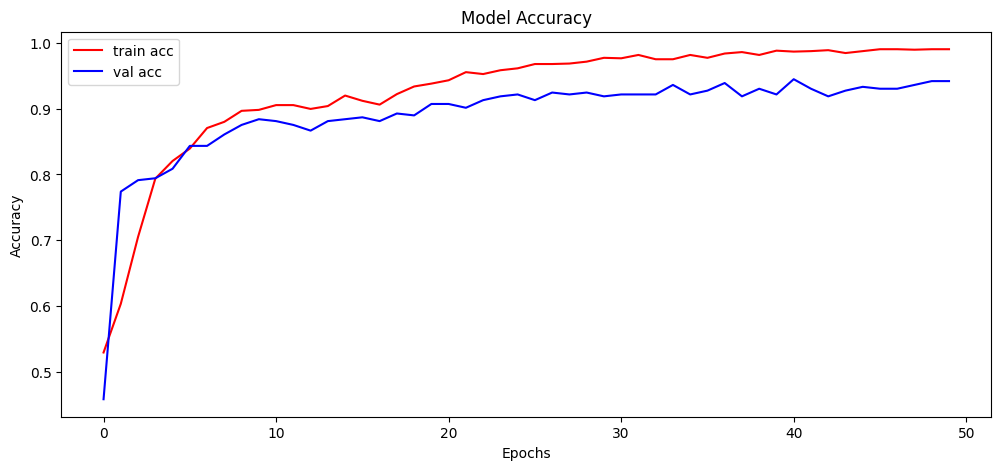

In [ ]:
# 12. Plot Accuracy and Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r', label='train acc')
plt.plot(history.history['val_accuracy'], color='b', label='val acc')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
# 13. Test Accuracy
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1] * 100}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9611 - loss: 0.1353
Test Accuracy: 96.05568647384644


In [ ]:
# 14. Predictions on Test Images
y_pred = model.predict(x_test)
for i in range(10):
    print(f"Real: {all_labels[np.argmax(y_test[i])]}, Predicted: {all_labels[np.argmax(y_pred[i])]}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Real: Potato___Early_blight, Predicted: Potato___Early_blight
Real: Tomato___Bacterial_spot, Predicted: Tomato___Bacterial_spot
Real: Potato___Early_blight, Predicted: Potato___Early_blight
Real: Potato___Early_blight, Predicted: Potato___Early_blight
Real: Corn_(maize)___Common_rust_, Predicted: Corn_(maize)___Common_rust_
Real: Potato___Early_blight, Predicted: Potato___Early_blight
Real: Potato___Early_blight, Predicted: Potato___Early_blight
Real: Corn_(maize)___Common_rust_, Predicted: Corn_(maize)___Common_rust_
Real: Potato___Early_blight, Predicted: Potato___Early_blight
Real: Potato___Early_blight, Predicted: Potato___Early_blight


/tmp/ipython-input-3772895478.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=label_list, palette="viridis")


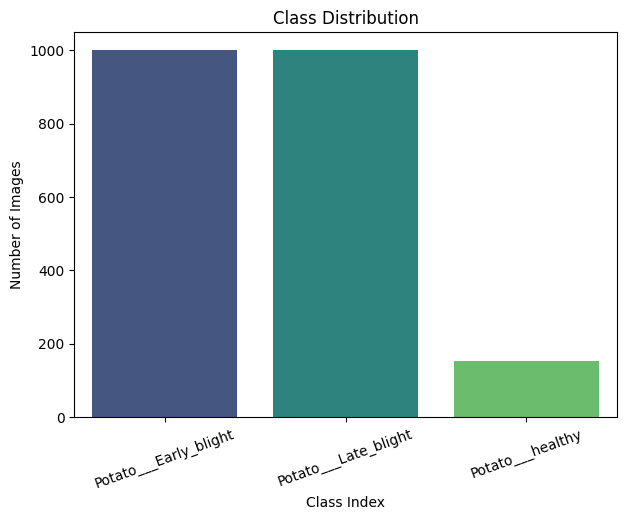

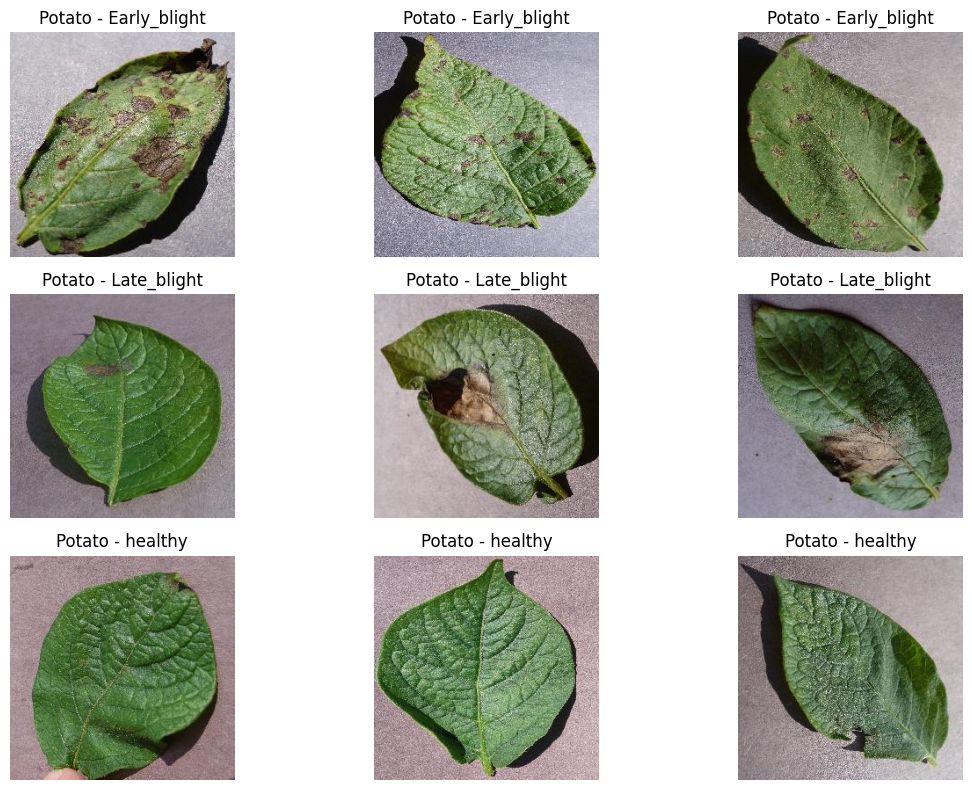

Class  Count
0  Potato___Early_blight      0
1   Potato___Late_blight      0
2       Potato___healthy      0

Unique image shapes in dataset:
   Height  Width  Channels
0     256    256         3


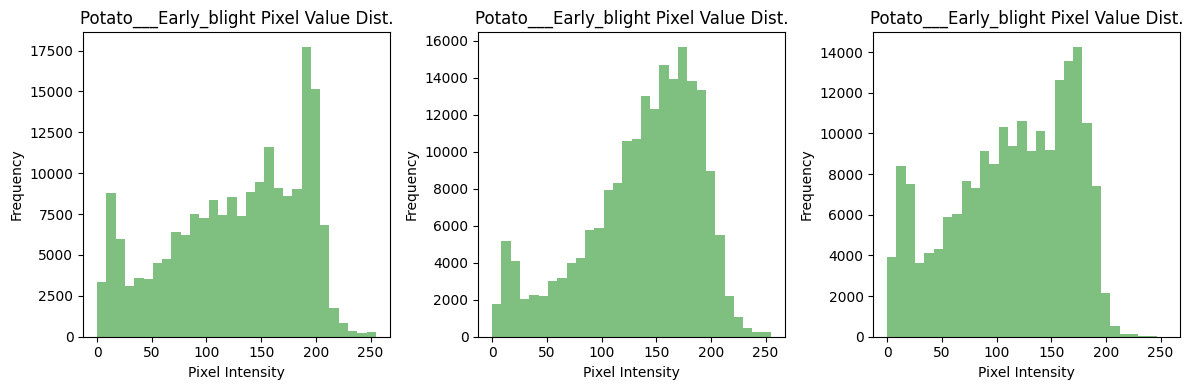

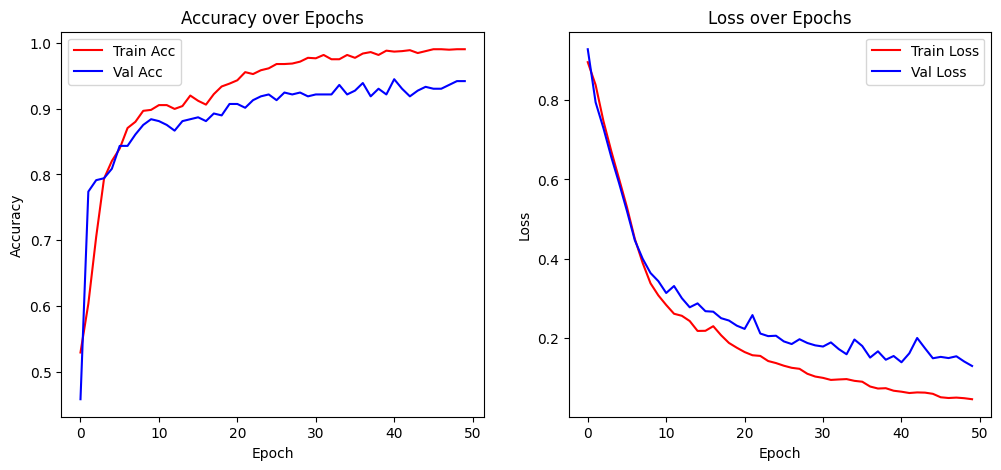

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


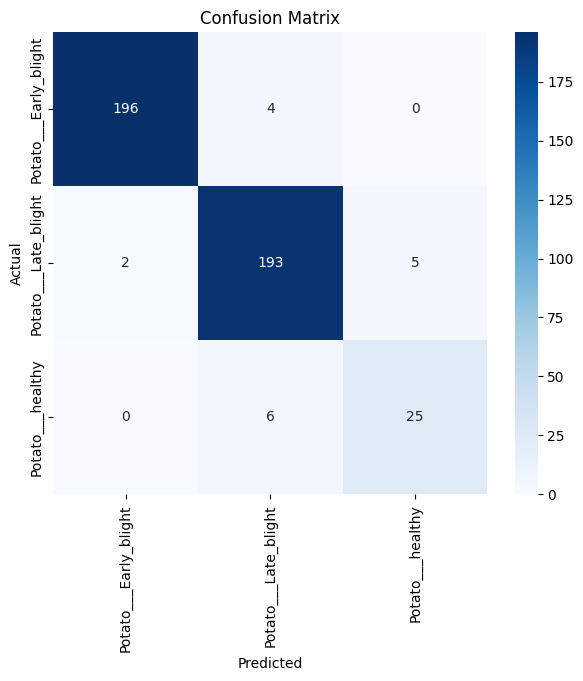

In [ ]:
import seaborn as sns
import numpy as np

# Set correct dataset path and class list for Colab/Kaggle
dataset_path = '/kaggle/input/plantdisease/PlantVillage'
all_labels = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

# 1. Show class distribution as a bar plot
plt.figure(figsize=(7, 5))
sns.countplot(x=label_list, palette="viridis")
plt.title("Class Distribution")
plt.xlabel("Class Index")
plt.ylabel("Number of Images")
plt.xticks(ticks=[0,1,2], labels=all_labels, rotation=20)
plt.show()

# 2. Display a few images per class
plt.figure(figsize=(12, 8))
for idx, c in enumerate(all_labels):
    img_dir = os.path.join(dataset_path, c)
    imgs = os.listdir(img_dir)
    for j in range(3):
        plt.subplot(len(all_labels), 3, idx*3 + j + 1)
        im = imread(os.path.join(img_dir, imgs[j]))
        plt.imshow(im)
        plt.axis('off')
        plt.title(f"{c.split('___')[0]} - {c.split('___')[-1]}")
plt.tight_layout()
plt.show()

# 3. Show class counts in a table
df_class_counts = pd.DataFrame(
    {"Class": all_labels,
     "Count": [np.sum(label_list==i) for i in range(len(all_labels))]}
)
display(df_class_counts)

# 4. Show image shape stats
img_shapes = np.array([img.shape for img in image_list])
shape_df = pd.DataFrame(img_shapes, columns=['Height', 'Width', 'Channels'])
print("Unique image shapes in dataset:")
print(shape_df.drop_duplicates())

# 5. Plot example image pixel value distributions
plt.figure(figsize=(12, 4))
for idx in range(3):
    plt.subplot(1, 3, idx+1)
    plt.hist(image_list[idx].flatten(), bins=30, color='green', alpha=0.5)
    plt.title(f"{all_labels[label_list[idx]]} Pixel Value Dist.")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 6. Plot training/validation accuracy and loss during training
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], 'r', label='Train Acc')
plt.plot(history.history['val_accuracy'], 'b', label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'r', label='Train Loss')
plt.plot(history.history['val_loss'], 'b', label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 7. Confusion Matrix for Test Set Predictions
from sklearn.metrics import confusion_matrix

y_true = np.argmax(y_test, axis=1)
y_pred_label = np.argmax(model.predict(x_test), axis=1)
cm = confusion_matrix(y_true, y_pred_label)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=all_labels, yticklabels=all_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
save_dir = '/content/drive/MyDrive/Colab Notebooks/programs/NNDL_plant_disease'


In [ ]:
# Save the full model (architecture+weights+optimizer)
model.save(f'{save_dir}/plant_disease_model.h5')

# Save only the model weights
model.save_weights(f'{save_dir}/plant_disease.weights.h5')

print("Model and weights saved to Google Drive.")


Model and weights saved to Google Drive.


In [ ]:
import pickle

# Save the model object as a pickle file (not recommended for production, but okay for backup)
with open(f'{save_dir}/plant_disease_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model also saved as .pkl for backup.")


Model also saved as .pkl for backup.


Saving downy-mildew-plant-disease-1024x512.jpg to downy-mildew-plant-disease-1024x512.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
Predicted class: Potato___Early_blight


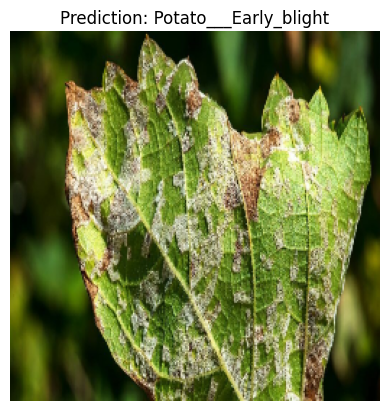

In [ ]:
# Import for file upload
from google.colab import files

# Allow user to upload an image
uploaded = files.upload()
for fn in uploaded.keys():
    test_image_path = fn  # The filename of the uploaded image

    # Load and preprocess the image
    img = cv2.imread(test_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (256, 256))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype('float16') / 255.0

    # Predict with trained model
    pred = model.predict(img_array)
    predicted_class = all_labels[np.argmax(pred)]

    print(f"Predicted class: {predicted_class}")

    # Display image and result
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis('off')
    plt.show()
